In [43]:
using StatsPlots, Plots, Measures
using Distributions, ARFIMA
using Statistics, StatsBase
using CSV, DataFrames
using Dates
using LsqFit
using SingularSpectrumAnalysis
using LaTeXStrings
using HypothesisTests

In [91]:
γ(X,h)=begin
    n=length(X)
    x=mean(X)
    sum(@. (X[h+1:end]-x)*(X[1:n-h]-x) )/n
end

γ (generic function with 1 method)

# Działanie

## Wczytanie danych

In [92]:
File=CSV.read("testset.csv", DataFrame);
file=File[:,[:tempm]];
N=length(file[:,:tempm])

100990

In [93]:
file[:,:Date]=[Date(File[i,:datetime_utc][1:8], "yyyymmdd") for i in 1:N];
file[:,:h]=[parse(Int,File[i,:datetime_utc][10:11]) for i in 1:N];

In [94]:
file=file[file[:,:tempm].!==missing,:];

In [95]:
file[end,:Date]

2017-04-24

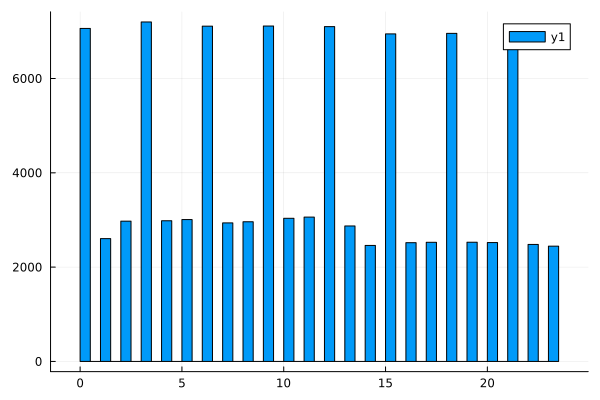

In [96]:
histogram(file[:,:h])

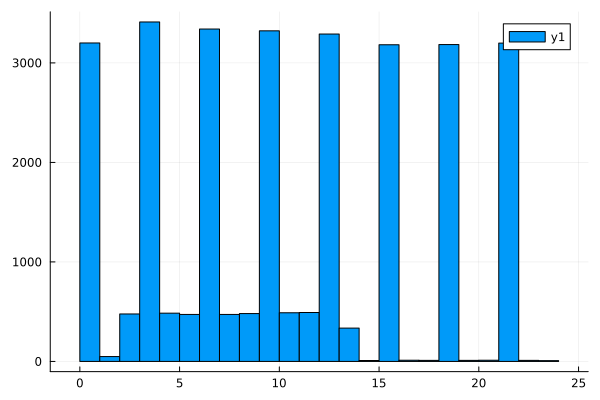

In [97]:
histogram(file[file[:,:Date].>=Date("2008-01-01"),:h])

In [98]:
file[1,:Date]

1996-11-01

## przekształcenie

In [122]:
size(file)

(100313, 3)

In [123]:
temp=file[:,:tempm];

In [124]:
qₘᵢₙ,qₘₐₓ=quantile(temp,0.25)-1.5*iqr(temp),quantile(temp,0.75)+1.5*iqr(temp)

(-0.5, 51.5)

In [125]:
file=file[(file[:,:tempm].>qₘᵢₙ) .& (file[:,:tempm].<qₘₐₓ), :];

In [126]:
size(file) #4 odstające

(100313, 3)

In [127]:
#X=combine(groupby(file,:Date),:tempm=>mean);
#X=X[(X[:,:Date].>=Date("2008-02-03")).&(X[:,:Date].<Date("2017-02-03")),:];

X=combine(groupby(file,:Date),:tempm=>mean);
X=X[(X[:,:Date].>=Date("2008-01-01")).&(X[:,:Date].<Date("2016-01-01")),:];
X=X[:,:tempm_mean];
fit_trend=curve_fit(model_trend,1:length(X),X,[1.,0.])
fit_trend.param
fit_trend.param[2]*365

In [128]:
minimum(file[:,:tempm])

1

In [129]:
X=combine(groupby(file,:Date),:tempm=>mean);

In [130]:
Res=X[(X[:,:Date].>=Date("2008-01-01")),:];

In [131]:
#Pes=Res[1:end-366]-Res[367:end];

In [132]:
X=X[(X[:,:Date].>=Date("2008-01-01")).&(X[:,:Date].<Date("2016-01-01")),:];

In [133]:
sum(X[:,:tempm_mean])

73014.81867231411

In [134]:
rename!(X, :Date => :time, :tempm_mean => :temp);

In [135]:
sum(X[2:end,:time]-X[1:end-1,:time].!=Day(1))

0

In [136]:
CSV.write("Data.csv",X)

"Data.csv"

In [137]:
X=X[:,:temp];

In [138]:
Res=Res[:,:tempm_mean];

In [139]:
N=length(X)

2922

In [140]:
argmax(X)

1630

In [141]:
minimum(X)

6.0

## Trend i sezonowość

### SingularSpectrumAnalysis

In [889]:
yt, ys = analyze(X, 20, robust=true)

([13.653451514588678, 13.67470788557458, 13.627778371445155, 13.585856541769989, 13.558271136165313, 13.51414029443027, 13.472879705360768, 13.394331600162694, 13.303674529768756, 13.207875361927389  …  13.53276222547573, 13.397983533686247, 13.26749786996031, 13.142886509140187, 13.068653611847788, 13.024482642543086, 13.000894878880361, 13.030412207104268, 13.116947623450661, 13.22207992249919], [-1.3563496987560604; -1.035381669155001; … ; 1.2378447158793373; 1.4508282356243662;;])

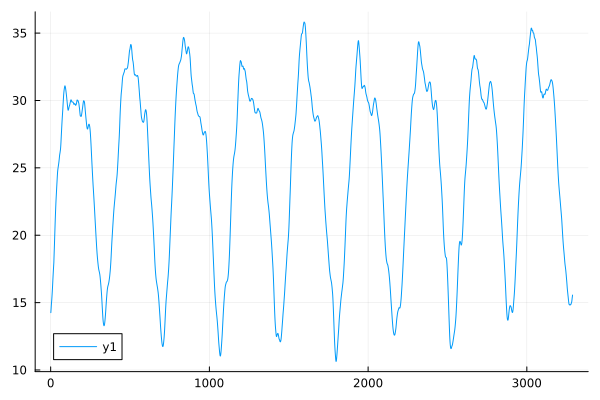

In [69]:
plot(yt)

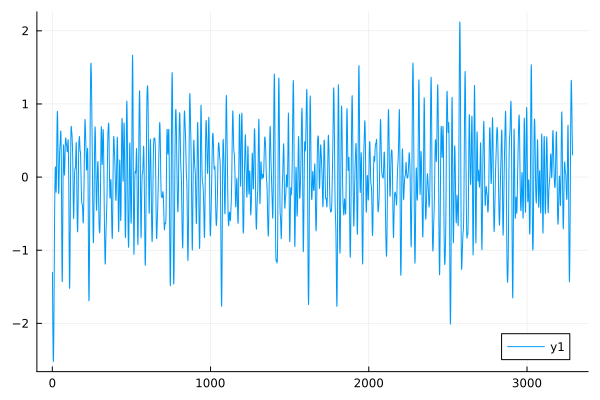

In [70]:
plot(ys)

In [22]:
Y=X.-ys.-yt;

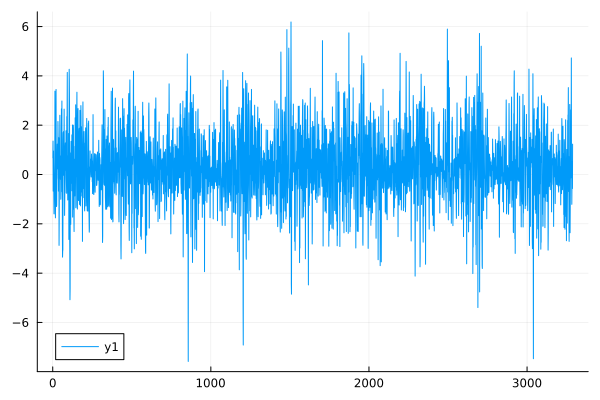

In [23]:
plot(Y)

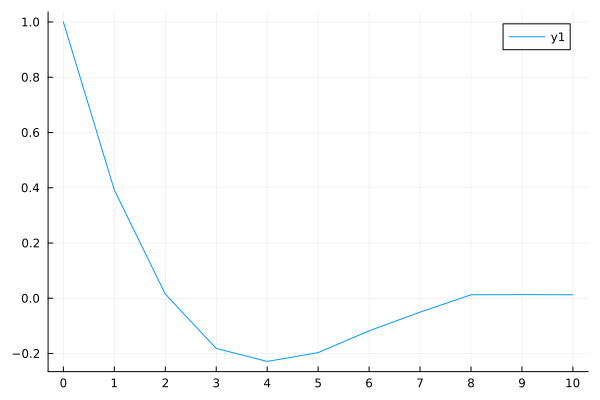

In [41]:
γ₀=γ(Y,0)
plot(0:1:10,h->γ(Y,h)/γ₀)
plot!(yticks=[i for i in -0.2:0.2:1])
plot!(xticks=[i for i in 0:10])

### Pół na pół

In [179]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [180]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([24.852176993111712, 9.467109909017854e-5], [14.727271664210804, 15.477366335309892, 14.227461006408983, 13.727555677508072, 10.281221777178592, 10.727745019706251, 9.602839690805343, 5.977934361904435, 6.603029033003523, 8.228123704102615  …  13.127953904761402, 12.628048575860493, 13.878143246959581, 13.628237918058673, 12.378332589157761, 9.753427260256853, 8.003521931355944, 8.753616602455033, 9.628711273554124, 10.128805944653212], [0.9999999999967198 1.0000000000235538; 0.9999999999967198 2.0000000000471077; … ; 0.9999999999967198 2921.0000000001573; 0.9999999999967198 2921.9999999998877], true, Float64[])

In [181]:
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [182]:
ans[2]*365

0.02074735749247046

In [183]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.2765342804424087

In [184]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

In [185]:
yt, ys = analyze(Y, 20, robust=true)

([-9.457963412328198, -9.524945756512805, -9.58730369282817, -9.660367024809704, -9.73853135273846, -9.821794766283757, -9.911375676797254, -10.014150033814643, -10.158228724265856, -10.323142824767269  …  -11.234118887200982, -11.339581598140066, -11.436228177469017, -11.519119123248846, -11.576191549107635, -11.62445309765858, -11.623036704783969, -11.576436416307054, -11.521536973593204, -11.382740802422052], [-0.9509255556996901 -0.4743124012981045; -0.8415502103584385 -0.6433792789124607; … ; 1.6161366159818238 0.2650304531133346; 1.5801603983858736 0.1097042662393834])

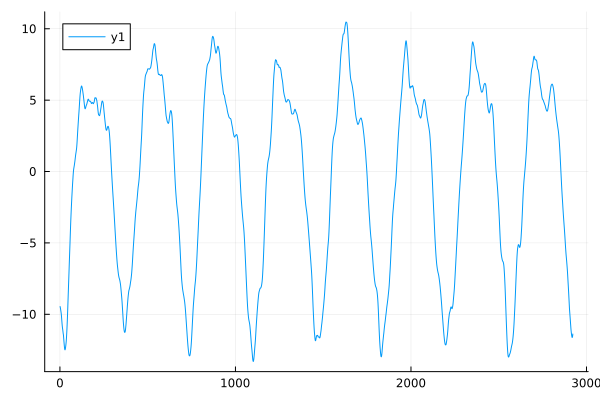

In [186]:
plot(yt)

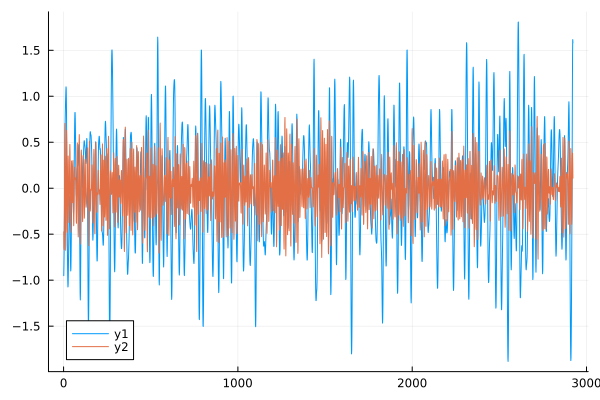

In [187]:
plot(ys)

In [77]:
W=Y.-yt;

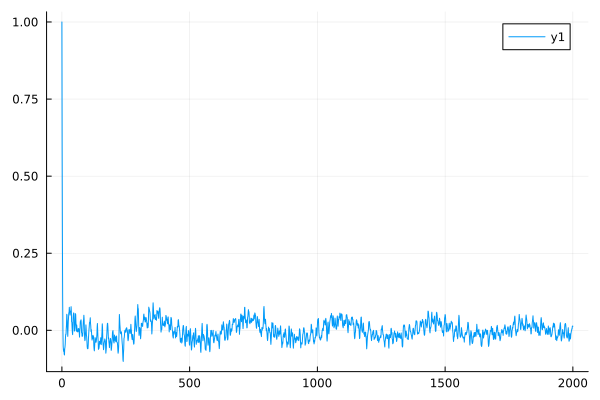

In [79]:
γ₀=γ(W,0)
plot(0:2000,h->γ(W,h)/γ₀)

### Własna przy złożeniu 30+

#### Trend

In [188]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [189]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([24.852176993111712, 9.467109909017854e-5], [14.727271664210804, 15.477366335309892, 14.227461006408983, 13.727555677508072, 10.281221777178592, 10.727745019706251, 9.602839690805343, 5.977934361904435, 6.603029033003523, 8.228123704102615  …  13.127953904761402, 12.628048575860493, 13.878143246959581, 13.628237918058673, 12.378332589157761, 9.753427260256853, 8.003521931355944, 8.753616602455033, 9.628711273554124, 10.128805944653212], [0.9999999999967198 1.0000000000235538; 0.9999999999967198 2.0000000000471077; … ; 0.9999999999967198 2921.0000000001573; 0.9999999999967198 2921.9999999998877], true, Float64[])

In [190]:
fit_trend.param

2-element Vector{Float64}:
 24.852176993111712
  9.467109909017854e-5

In [191]:
ans[2]*365

0.03455495116791517

In [192]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.2765342804424087

In [193]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

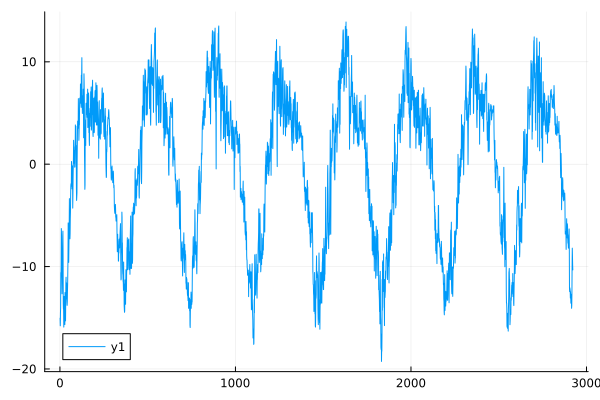

In [194]:
plot(Y)

#### Sezonowość

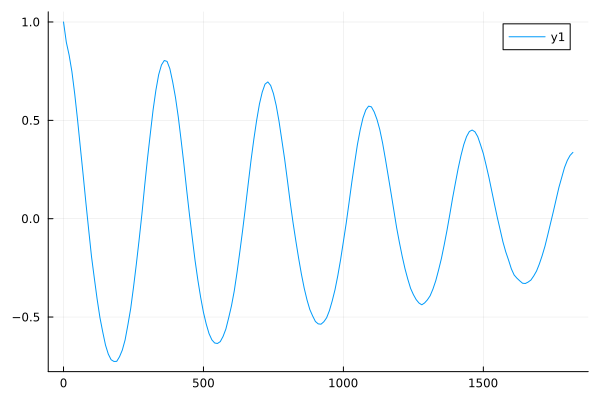

In [195]:
γ₀=γ(Y,0)
plot(0:10:365*5,h->γ(Y,h)/γ₀)

In [211]:
W=X[1:end-365]-X[366:end];

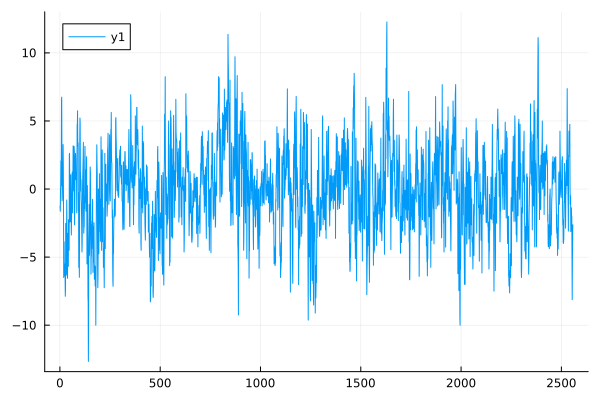

In [212]:
plot(W)

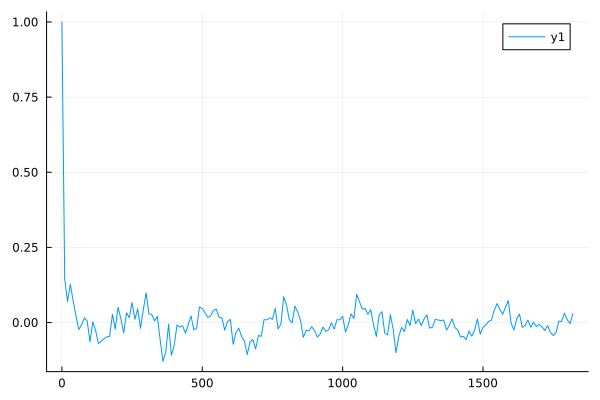

In [213]:
γ₀=γ(W,0)
plot(0:10:365*5,h->γ(W,h)/γ₀)

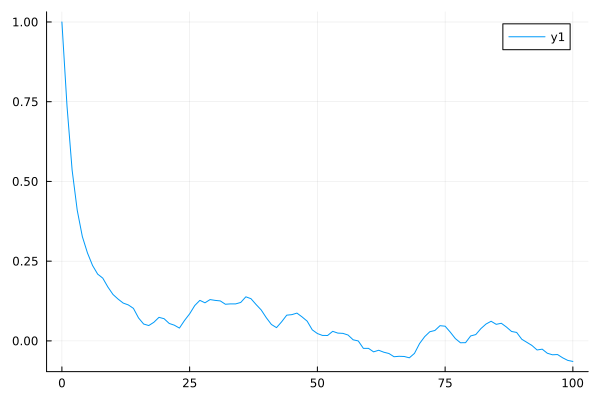

In [214]:
γ₀=γ(W,0)
plot(0:1:100,h->γ(W,h)/γ₀)

In [220]:
fit_trend=curve_fit(model_trend,1:length(W),W,[1.,0])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([-0.24539209595668232, 0.00012716469246919015], [1.0047350687357868, 1.379862233428256, -0.15572488759356123, -0.5365501038534717, -2.3161848439229074, -0.4946291078018672, -2.119501943109398, -6.744374778416929, -6.994247613724459, -3.3691204490319904  …  2.703623540454814, 2.9537507051472836, 1.4538778698397525, 2.3290050345322215, 2.079132199224691, 5.07925936391716, 8.204386528609628, 5.329513693302099, 3.9546408579945678, 2.7047680226870368], [1.0000000000052196 1.0000000000052196; 1.0000000000052196 1.999999999992105; … ; 1.0000000000235538 2555.999999999994; 0.9999999999868854 2556.999999999981], true, Float64[])

In [221]:
fit_trend.param

2-element Vector{Float64}:
 -0.24539209595668232
  0.00012716469246919015

In [223]:
V=W.-model_trend.(1:length(W),Ref(fit_trend.param));

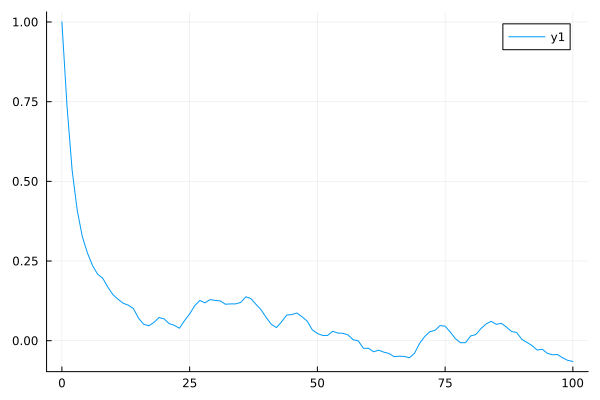

In [225]:
γ₀=γ(V,0)
plot(0:1:100,h->γ(V,h)/γ₀)

In [278]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])

model_ses (generic function with 1 method)

In [241]:
fit_ses=curve_fit(model_ses,1:length(V),V,[1.,200.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([1.0, 202.66699070243396, 2.6775952100168876], [1.4243262899914895, 1.771114946109211, 0.20681329189799497, -0.203074885242219, -2.0120930820927145, -0.2202130588415857, -1.8750253424148984, -6.530072587220652, -6.810325793279201, -3.215755762665946  …  2.6942041350069403, 2.975331994310724, 1.5064391122990544, 2.4124957148013557, 2.193472076196419, 5.224338547981035, 8.380065587264589, 5.535623785162024, 4.190983895058133, 2.971116860715845], [0.0 0.00013885530270795369 -0.9077131743905722; 0.0 0.000281556370214139 -0.9202832796212798; … ; 0.0 -0.379921013081476 0.9716696806993119; 0.0 -0.37702141971543096 0.9638767016807919], true, Float64[])

In [242]:
fit_ses.param

3-element Vector{Float64}:
   1.0
 202.66699070243396
   2.6775952100168876

In [243]:
U=V.-model_ses.(1:length(V),Ref(fit_ses.param));

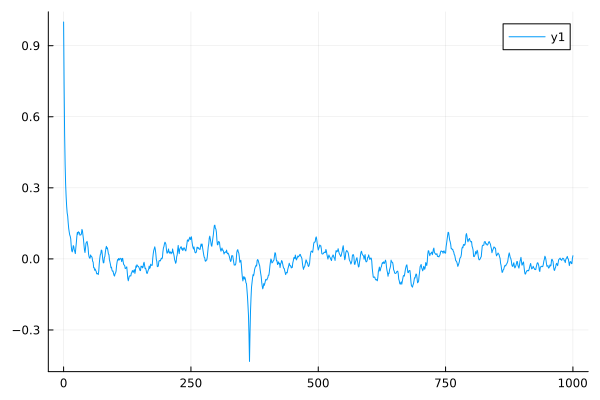

In [307]:
γ₀=γ(U,0)
plot(0:1:1000,h->γ(U,h)/γ₀)

In [305]:
fit_ses=curve_fit(model_ses,1:length(V),V,[12.,500.,3.])
U=V.-model_ses.(1:length(V),Ref(fit_ses.param));
γ₀=γ(U,0)
print(fit_ses.param)


[0.5935463134872346, 512.9783611831584, 3.6621625223354073]

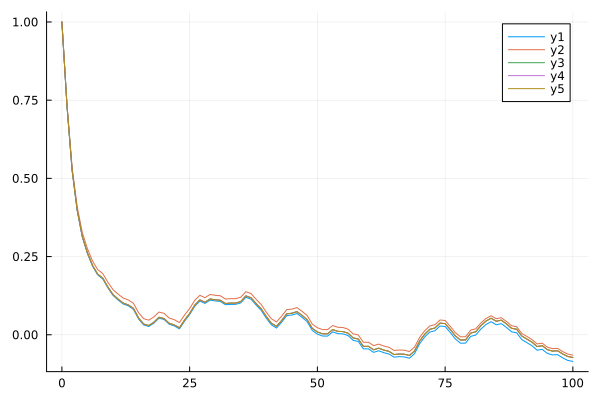

In [306]:
γ₀=γ(U,0)
plot!(0:1:100,h->γ(U,h)/γ₀)

### Różnicowanie

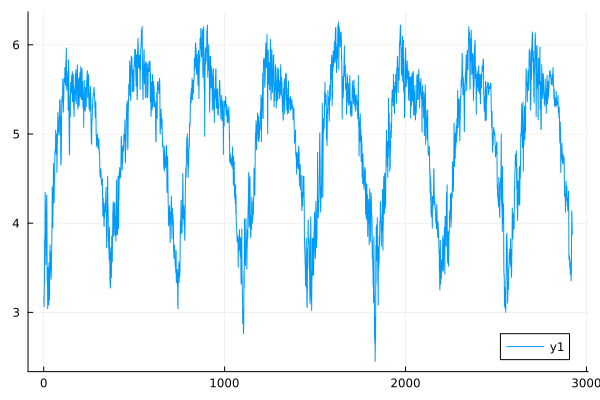

In [436]:
plot(sqrt.(X))


In [438]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [439]:
fit_trend=curve_fit(model_trend,1:N,X,[1.,0.])
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [440]:
ans[2]*365

0.02074735749247046

In [441]:
model_trend(N,fit_trend.param)-model_trend(1,fit_trend.param)

0.26308276196804314

In [442]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

In [444]:
W=X[1:end-365]-X[366:end];

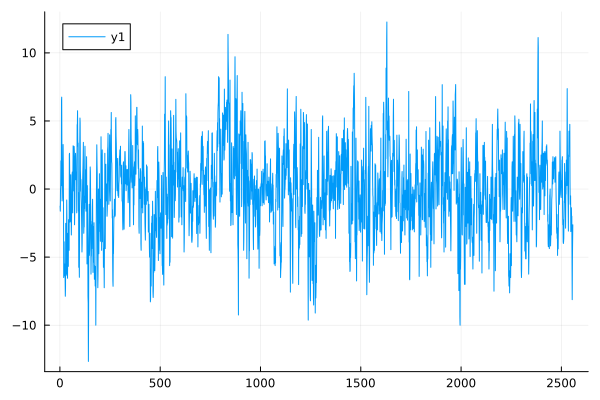

In [445]:
plot(W)

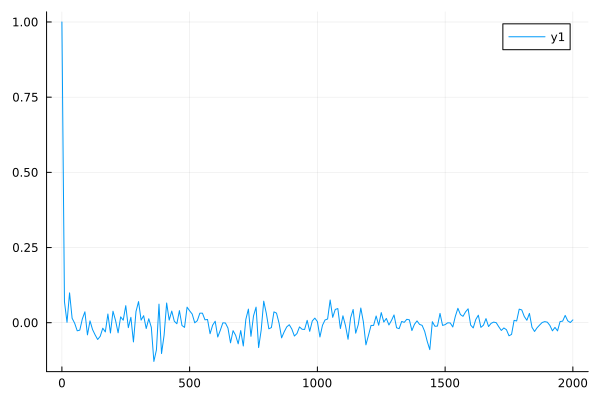

In [489]:
γ₀=γ(W,0)
plot(0:10:2000,h->γ(W,h)/γ₀)

In [450]:
fit_trend=curve_fit(model_trend,1:N,log.(X),[1.,0.])
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [451]:
ans[2]*365

0.02074735749247046

In [486]:
Y=log.(X);

In [487]:
W=Y[1:end-365]-Y[366:end];

In [488]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

51.17686261621028

In [484]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

55.31119443436681

In [481]:
γ₀=γ(W,0)
sum(abs(γ(W,h)) for h in 20:2000)/γ₀

60.17246845817378

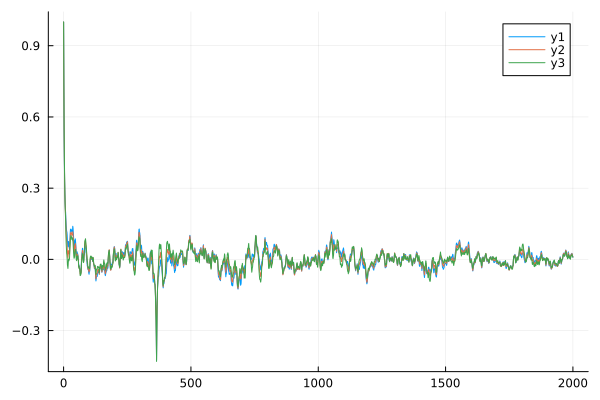

In [467]:
γ₀=γ(W,0)
plot!(0:2000,h->γ(W,h)/γ₀)

### Stabilizacja wariancji + różnicowanie sezonowe

In [890]:
@. model(x,p)=p[1]+p[2]*x

model (generic function with 1 method)

In [891]:
fit=curve_fit(model,0:length(X)-1,X,[1.,1.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([24.856418456826063, 9.006599708569974e-5], [14.731418456826063, 15.481508522823148, 14.231598588820233, 13.731688654817319, 10.285350149385833, 10.731868786811493, 9.606958852808578, 5.982048918805663, 6.607138984802749, 8.232229050799834  …  13.118690640339622, 12.618780706336707, 13.868870772333793, 13.618960838330878, 12.369050904327963, 9.744140970325049, 7.994231036322134, 8.744321102319219, 9.619411168316304, 10.119501234313393], [1.0000000000066098 0.0; 1.0000000000066098 1.0000000000235538; … ; 1.0000000000066098 2919.9999999998404; 1.0000000000066098 2920.999999999864], true, Float64[])

In [892]:
fit.param

2-element Vector{Float64}:
 24.856418456826063
  9.006599708569974e-5

In [893]:
fit.param[2]*365*10

0.32874088936280405

In [894]:
X=X.-model.(0:length(X)-1,Ref([0,fit.param[2]]))

2922-element Vector{Float64}:
 10.125
  9.374909934002915
 10.62481986800583
 11.124729802008742
 14.571068307440228
 14.124549670014572
 15.249459604017487
 18.8743695380204
 18.249279472023314
 16.62418940602623
 13.999099340029144
 12.499009274032057
 13.748919208034971
  ⋮
 11.487907948480613
 12.362817882483528
 11.737727816486442
 12.237637750489357
 10.98754768449227
 11.237457618495185
 12.4873675524981
 15.112277486501014
 16.86218742050393
 16.112097354506844
 15.237007288509757
 14.736917222512671

In [895]:
λ=1.45915768222621

1.45915768222621

In [896]:
temp=X.^(λ);
tmp=(X).^(0.01);
temp2=log.(X);

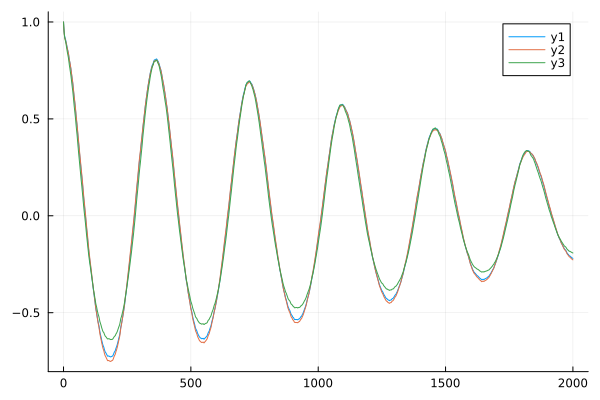

In [897]:
γ₀=γ(X,0)
plot(0:2000,h->γ(X,h)/γ₀)
γ₀=γ(temp,0)
plot!(0:2000,h->γ(temp,h)/γ₀)
γ₀=γ(tmp,0)
plot!(0:2000,h->γ(tmp,h)/γ₀)

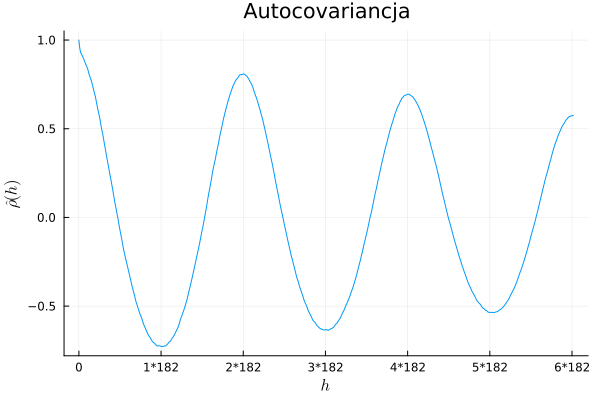

In [898]:
γ₀=γ(X,0)
plot(0:365*3,h->γ(X,h)/γ₀)
plot!(leg=false,dpi=500,title="Autocovariancja",ylabel=L"$\hat{\rho}(h)$", xlabel=L"$h$")
plot!(xticks=([i*182 for i in 0:6],[i!=0 ? "$i"*"*182" : "0" for i in 0:6]))
plt1=plot!()

In [899]:
savefig(plt1,"tex/Budnik/img/auto_dry.png")

"C:\\Git\\Kaszcz\\Raport 2\\tex\\Budnik\\img\\auto_dry.png"

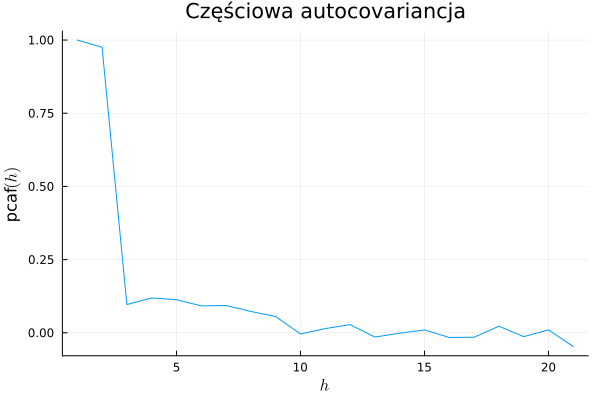

In [900]:
plot(pacf(X,0:20),leg=false,dpi=500,title="Częściowa autocovariancja",ylabel=L"pcaf$(h)$", xlabel=L"$h$")
plt2=plot!()

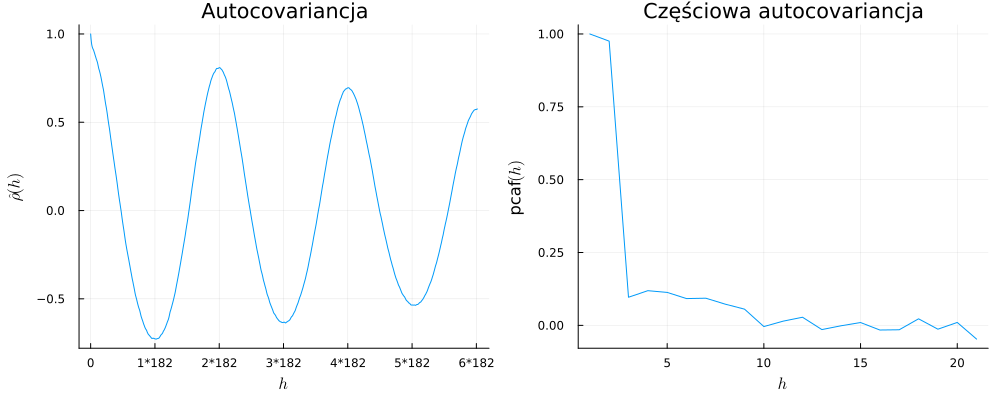

In [901]:
plot!(plt1,plt2, size=(1000,400), bottom_margin=5mm, left_margin=5mm)

In [902]:
savefig(plot!(),"tex/Budnik/img/auto_dry.png")

"C:\\Git\\Kaszcz\\Raport 2\\tex\\Budnik\\img\\auto_dry.png"

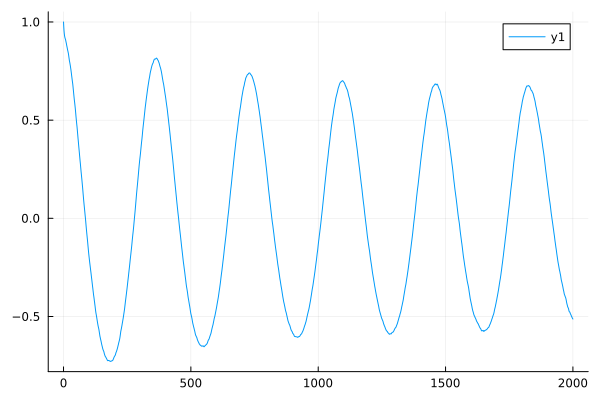

In [903]:
γ₀=γ(X,0)
plot(0:2000,h->γ(X,h)*(1+h^3/6000000000)/γ₀)

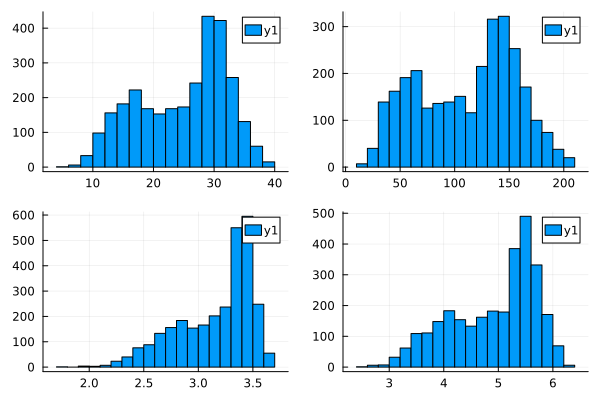

In [904]:
plot(histogram(X),histogram(X.^λ),histogram(log.(X)), histogram(sqrt.(X)), layout=(2,2))

In [905]:
?twinx

search: twinx twiny ExactMannWhitneyUTest ApproximateMannWhitneyUTest



```
twinx(sp)
```

Adds a new, empty subplot overlayed on top of `sp`, with a mirrored y-axis and linked x-axis.


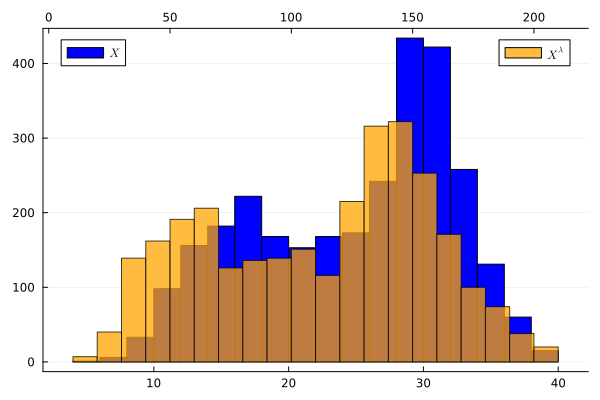

In [906]:
histogram(X,c=:blue, label=L"X",leg=:topleft)
histogram!(twiny(),(X.^λ), alpha=0.75,c=:orange, label=L"X^λ")
#histogram!(twiny(),log.(X), alpha=0.75,c=:orange, label=L"\ln X")
savefig(plot!(dpi=500),"tex/Budnik/img/BoxCox.png");
plot!()

In [907]:
W=Y[1:end-365]-Y[366:end];

In [908]:
W=temp[1:end-365]-temp[366:end];
W2=temp2[1:end-365]-temp2[366:end];

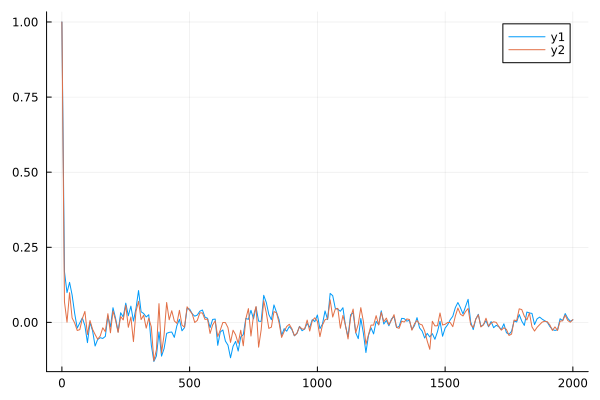

In [909]:
γ₀=γ(W,0)
plot(0:10:2000,h->γ(W,h)/γ₀)
γ₀=γ(W2,0)
plot!(0:10:2000,h->γ(W2,h)/γ₀)

In [910]:
maximum(abs(γ(W,h))/γ₀ for h in 20:10:2000)

2466.4458117571326

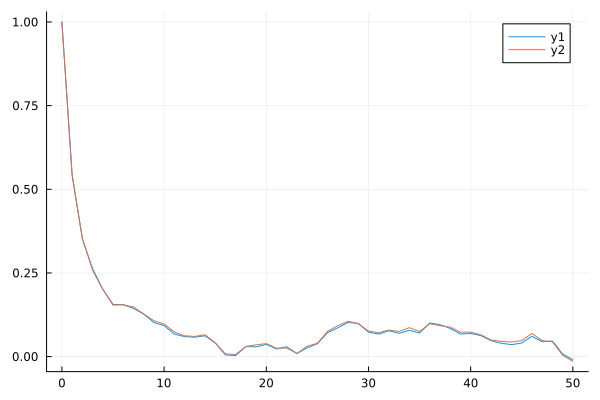

In [911]:
γ₀=Γ(W,0)
plot(0:50,h->Γ(W,h)/γ₀)
γ₀=Γ(W2,0)
plot!(0:50,h->Γ(W2,h)/γ₀)

In [912]:
ft(a)=Y[1:end-a]-Y[a+1:end]

ft (generic function with 1 method)

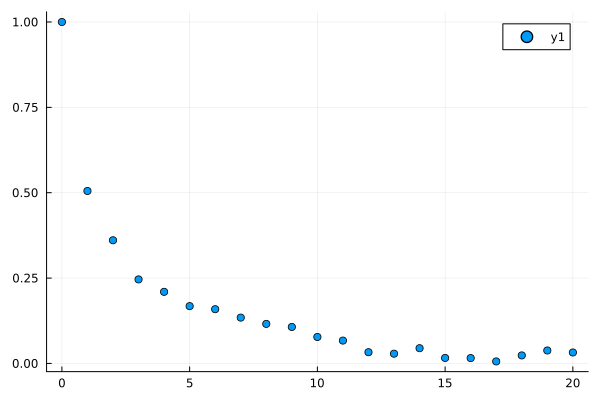

In [913]:
W=ft(366);
γ₀=Γ(W,0)
scatter(0:20,h->Γ(W,h)/γ₀)

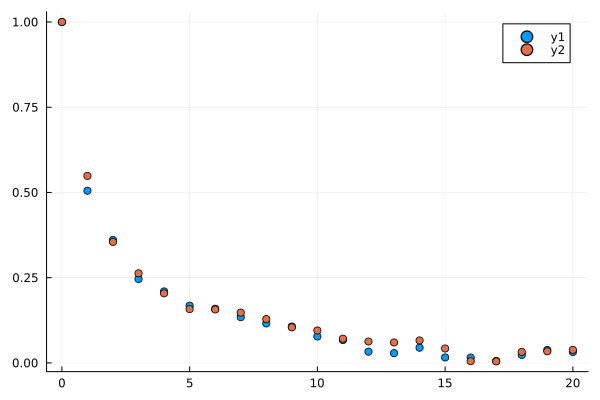

In [914]:
W=ft(365);
γ₀=Γ(W,0)
scatter!(0:20,h->Γ(W,h)/γ₀)

In [915]:
gt(a;m=0,N=10)=begin
    W1=ft(366)
    W2=ft(a)
    g1=γ(W1,0)
    g2=γ(W2,0)
    sum(γ.(Ref(W1),m:N)./g1.-γ.(Ref(W2),m:N)./g2)
end

gt (generic function with 1 method)

In [916]:
gt.(360:370,m=2,N=8)

11-element Vector{Float64}:
 -0.14967023241870434
 -0.045858922437248484
  0.013371173909783873
  0.024579664045883187
  0.03150266551338096
 -0.004411715371462677
  0.0
 -0.005018176644063427
 -0.009460763621752938
 -0.03251611063075352
 -0.07150088621425368

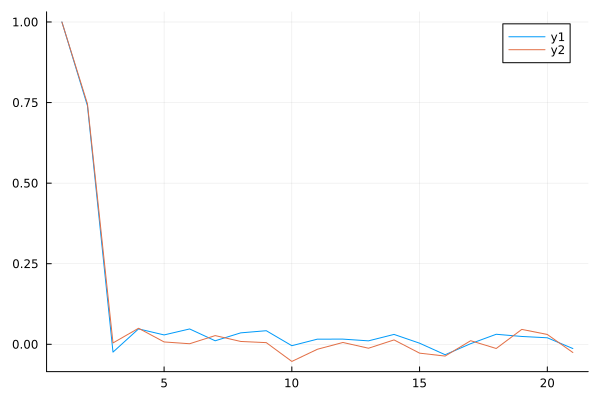

In [917]:
plot(pacf(W,0:20))
plot!(pacf(W2,0:20))

In [918]:
W=X[1:end-365]-X[366:end];

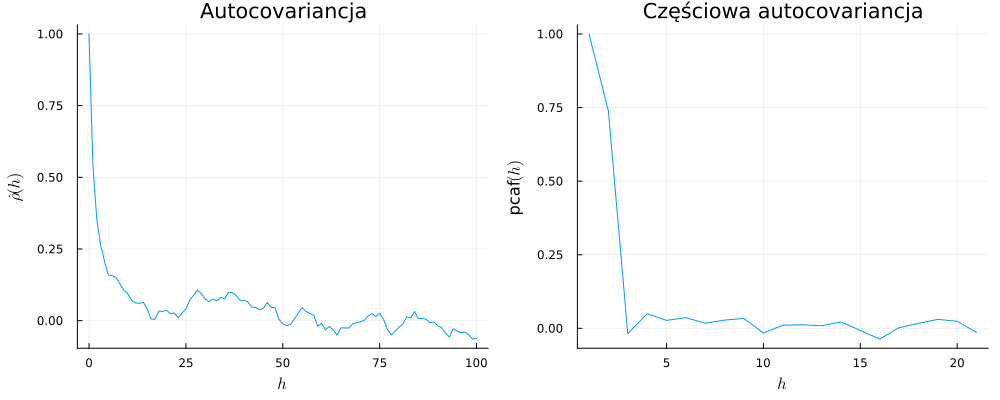

In [919]:
γ₀=Γ(W,0)
plot(0:100,h->Γ(W,h)/γ₀)
plot!(leg=false,dpi=500,title="Autocovariancja",ylabel=L"$\hat{\rho}(h)$", xlabel=L"$h$")
plt1=plot!()
plot(pacf(W,0:20),leg=false,dpi=500,title="Częściowa autocovariancja",ylabel=L"pcaf$(h)$", xlabel=L"$h$")
plt2=plot!()
plot!(plt1,plt2, size=(1000,400), bottom_margin=5mm, left_margin=5mm)

In [920]:
savefig(plot!(),"tex/Budnik/img/auto_wet.png")

"C:\\Git\\Kaszcz\\Raport 2\\tex\\Budnik\\img\\auto_wet.png"

### Kurwa

In [146]:
Y=X[1:end-365]-X[366:end];

In [148]:
Pes=Res[1:end-365]-Res[366:end];

In [151]:
Pes[1:length(Y)]==Y

true

In [158]:
predic=DataFrame()

""
""


In [159]:
predic[:,:X]=Pes[length(Y):end];

In [161]:
CSV.write("tredic.csv",predic)

"tredic.csv"

In [73]:
temp=DataFrame()

""
""


In [74]:
temp[:,:X]=Y;

In [90]:
Pes[1:end]

3036-element Vector{Float64}:
 -0.875
 -1.3392857142857135
 -0.20833333333333393
 -1.375
  0.6964285714285712
  0.75
  2.875
  7.375
  4.75
  1.75
  0.875
 -0.375
  1.0357142857142865
  ⋮
  0.5333333333333314
  1.25
  1.9027777777777786
  2.625
  3.131944444444443
  0.6666666666666643
  1.125
 -0.5
 -0.1875
  1.1000000000000014
  0.375
 -0.08333333333333215

In [89]:
Y

2557-element Vector{Float64}:
 -1.25
 -1.625
 -0.08928571428571352
  0.2916666666666661
  2.071428571428571
  0.25
  1.875
  6.5
  6.75
  3.125
 -0.875
 -0.625
  0.875
  ⋮
 -0.5
 -3.125
 -2.625
 -2.875
 -1.375
 -2.25
 -2.0
 -5.0
 -8.125
 -5.25
 -3.875
 -2.625

In [1098]:
CSV.write("Y.csv",temp)

"Y.csv"

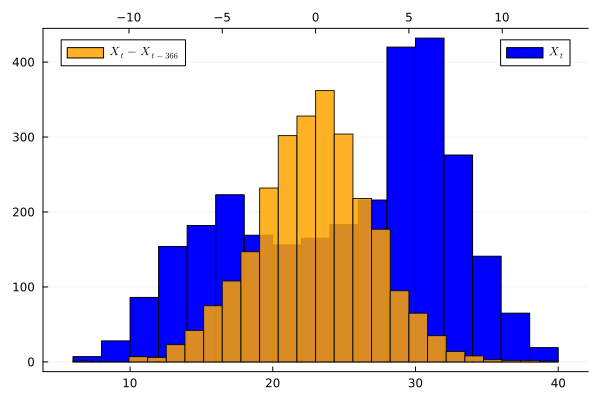

In [1099]:
histogram(X,c=:blue, label=L"X_t",leg=:topright)
histogram!(twiny(),(Y), alpha=0.85,c=:orange, label=L"X_t-X_{t-366}", leg=:topleft)
#histogram!(twiny(),log.(X), alpha=0.75,c=:orange, label=L"\ln X")
savefig(plot!(dpi=500),"tex/Budnik/img/wet.png");
plot!()

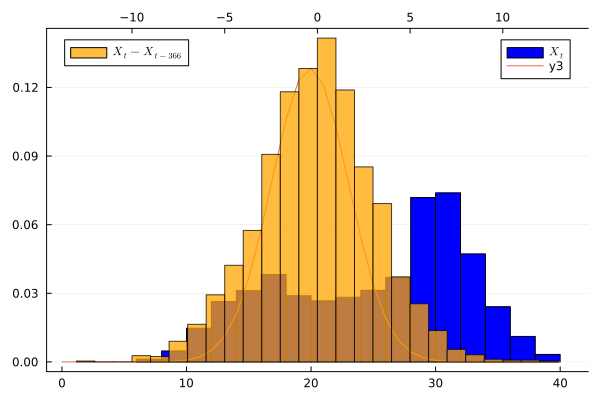

In [1090]:
histogram(X,c=:blue, label=L"X_t",leg=:topright, normed=true)

histogram!(twiny(),Y, alpha=0.75,c=:orange, label=L"X_t-X_{t-366}", leg=:topleft, normed=true)
plot!(0:40,h->pdf(Normal(mean(Y),√var(Y)),(h-20)/1))
#histogram!(twiny(),log.(X), alpha=0.75,c=:orange, label=L"\ln X")
#plot!(h->pdf(Normal(mean(Y),√var(Y)),h))
#savefig(plot!(dpi=500),"tex/Budnik/img/wet.png");
#plot!()

plot!()

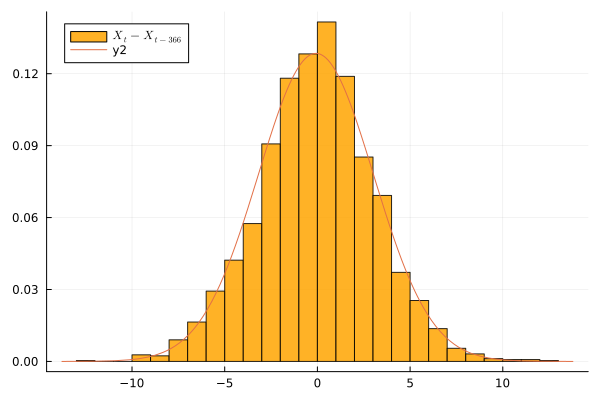

In [1063]:
histogram(Y, alpha=0.85,c=:orange, label=L"X_t-X_{t-366}", leg=:topleft, normed=true)
plot!(h->pdf(Normal(mean(Y),√var(Y)),h))

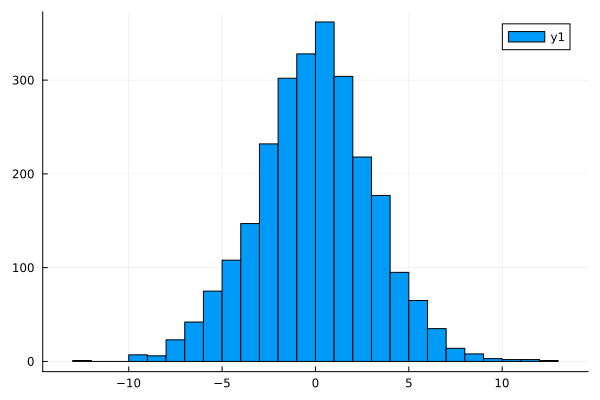

In [1008]:
histogram(Y)

2557-element Vector{Float64}:
 -1.25
 -1.625
 -0.08928571428571352
  0.2916666666666661
  2.071428571428571
  0.25
  1.875
  6.5
  6.75
  3.125
 -0.875
 -0.625
  0.875
  ⋮
 -0.5
 -3.125
 -2.625
 -2.875
 -1.375
 -2.25
 -2.0
 -5.0
 -8.125
 -5.25
 -3.875
 -2.625

In [1012]:
W=Y;

## ADF Test

In [921]:
?ADFTest

search: ADFTest WaldWolfowitzTest lastdayofquarter



```
ADFTest(y::AbstractVector{T}, deterministic::Symbol, lag::Int) where T<:Real
```

Compute the augmented Dickey-Fuller unit root test.

`y` is the time series to be tested, `deterministic` determines the deterministic terms (options: `:none`, `:constant`, `:trend`, `:squared_trend`) and `lag` the number of lagged first-differences included in the test regression, respectively.

Critical values and asymptotic p-values are computed based on response surface regressions following MacKinnon (2010) and MacKinnon (1994), respectively. These may differ slightly from those reported in other regression packages as different algorithms might be used.

# References

  * James G. MacKinnon, 2010, "Critical values for cointegration tests," QED Working Paper No. 1227, 2010, [link](http://ideas.repec.org/p/qed/wpaper/1227.html).
  * James G. MacKinnon, 1994, "Approximate Asymptotic Distribution Functions for Unit-Root and Cointegration Tests", Journal of Business & Economic Statistics, Vol. 12, No. 2, pp. 167-176, [link](http://www.jstor.org/stable/1391481).

# External links

  * [Augmented Dickey-Fuller test on Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)


In [1013]:
ADFTest(X,:trend,365)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.236848

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.2619

Details:
    sample size in regression:          2556
    number of lags:                     365
    ADF statistic:                      -2.63981
    Critical values at 1%, 5%, and 10%: [-3.96187 -3.41199 -3.12794]


In [1014]:
ADFTest(W,:none,365)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.293288

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     0.0002

Details:
    sample size in regression:          2191
    number of lags:                     365
    ADF statistic:                      -3.80304
    Critical values at 1%, 5%, and 10%: [-2.56661 -1.94111 -1.61672]


In [1015]:
?ADFTest

search: ADFTest WaldWolfowitzTest lastdayofquarter



```
ADFTest(y::AbstractVector{T}, deterministic::Symbol, lag::Int) where T<:Real
```

Compute the augmented Dickey-Fuller unit root test.

`y` is the time series to be tested, `deterministic` determines the deterministic terms (options: `:none`, `:constant`, `:trend`, `:squared_trend`) and `lag` the number of lagged first-differences included in the test regression, respectively.

Critical values and asymptotic p-values are computed based on response surface regressions following MacKinnon (2010) and MacKinnon (1994), respectively. These may differ slightly from those reported in other regression packages as different algorithms might be used.

# References

  * James G. MacKinnon, 2010, "Critical values for cointegration tests," QED Working Paper No. 1227, 2010, [link](http://ideas.repec.org/p/qed/wpaper/1227.html).
  * James G. MacKinnon, 1994, "Approximate Asymptotic Distribution Functions for Unit-Root and Cointegration Tests", Journal of Business & Economic Statistics, Vol. 12, No. 2, pp. 167-176, [link](http://www.jstor.org/stable/1391481).

# External links

  * [Augmented Dickey-Fuller test on Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)


# Dobranie modelu

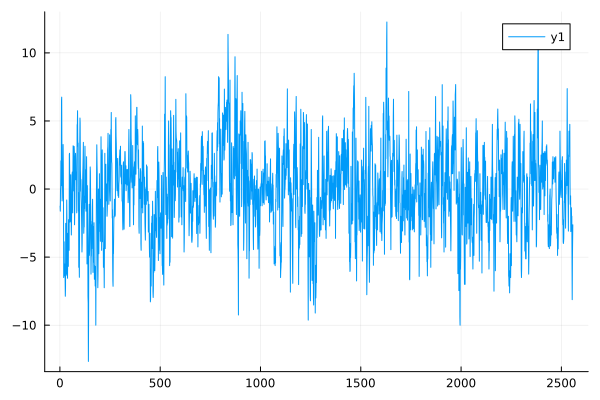

In [1100]:
plot(W)

In [1101]:
CSV.write("w.csv",  Tables.table(W), writeheader=["X"])

"w.csv"

Gotowy kod w pythonie :'<

In [1102]:
pq=CSV.read("pq.csv", DataFrame);

In [1103]:
pq

,Column1,p,q,AIC,BIC,HQIC
,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,0,13053.2,13064.9,13057.5
2,1,0,1,11716.4,11733.9,11722.7
3,2,0,2,11333.5,11356.9,11341.9
4,3,0,3,11180.9,11210.1,11191.5
5,4,0,4,11124.3,11159.4,11137.0
6,5,0,5,11091.0,11131.9,11105.8
7,6,0,6,11072.7,11119.5,11089.7
8,7,0,7,11070.7,11123.3,11089.7
9,8,0,8,11060.7,11119.2,11081.9


In [1104]:
argmin(pq[:,:AIC])

23

In [1107]:
argmin(pq[:,:HQIC])

23

In [1108]:
pq[[23,54],:]

,Column1,p,q,AIC,BIC,HQIC
,Int64,Int64,Int64,Float64,Float64,Float64
1,22,2,2,11027.3,11062.3,11040.0
2,53,5,3,11030.8,11089.2,11052.0


In [1109]:
sort(pq,[:AIC])

,Column1,p,q,AIC,BIC,HQIC
,Int64,Int64,Int64,Float64,Float64,Float64
1,22,2,2,11027.3,11062.3,11040.0
2,31,3,1,11027.6,11062.7,11040.3
3,23,2,3,11028.3,11069.2,11043.1
4,41,4,1,11028.3,11069.2,11043.1
5,66,6,6,11028.6,11110.4,11058.2
6,52,5,2,11029.7,11082.3,11048.7
7,33,3,3,11029.9,11076.7,11046.9
8,32,3,2,11030.0,11070.9,11044.8
9,24,2,4,11030.2,11077.0,11047.2


In [1110]:
PQ=zeros(5,5,3);

In [1111]:
for i in 1:5
    for j in 1:5
        PQ[i,j,:]=Vector(pq[10*(i-1)+j,[:AIC,:BIC,:HQIC]])
    end
end

In [1112]:
argmin(PQ[:,:,1]),argmin(PQ[:,:,2]),argmin(PQ[:,:,3])

(CartesianIndex(3, 3), CartesianIndex(2, 1), CartesianIndex(3, 3))

Za każdym razem $p=2$, $q=2$

In [1113]:
PQ[:,:,1]

5×5 Matrix{Float64}:
 13053.2  11716.4  11333.5  11180.9  11124.3
 11039.6  11040.7  11035.9  11034.7  11032.6
 11040.8  11040.5  11027.3  11028.3  11030.2
 11036.6  11027.6  11030.0  11029.9  11031.7
 11036.7  11028.3  11030.4  11032.8  11030.8

In [1114]:
AIC

5×5 Matrix{Float64}:
 13053.2  11716.4  11333.5  11180.9  11124.3
 11039.6  11040.7  11035.9  11034.7  11032.6
 11040.8  11040.5  11027.3  11028.3  11030.2
 11036.6  11027.6  11030.0  11029.9  11031.7
 11036.7  11028.3  11030.4  11032.8  11030.8

In [1115]:
AIC=PQ[:,:,1];

In [1122]:
txt="\t\\begin{table}[H]\n"
txt*="\t\t\\centering\n"
txt*="\t\t\\begin{tabularx}{4\\textwidth/5}{|Y|Y|Y|Y|Y|Y|}\n"
txt*="\t\t\t\\hline\n"
txt*="\t\t\t    "*prod("& \$q=$i\$ " for i in 0:4)*"\\\\\\hline\n"
for i in 1:5
    txt*="\t\t\t\$p=$(i-1)\$ "
    for j in 1:5
        if i==3 & j==3
            txt*="& \\textcolor{red}{$(round(AIC[i,j],digits=1))} "
        else
            txt*="& $(round(AIC[i,j],digits=1)) "
        end
    end
    txt*="\\\\\\hline\n"
end
txt*="\t\t\\end{tabularx}\n"
txt*="\t\\end{table}"
print(txt)

	\begin{table}[H]
		\centering		\begin{tabularx}{4\textwidth/5}{|Y|Y|Y|Y|Y|Y|}
			\hline
			    & $q=0$ & $q=1$ & $q=2$ & $q=3$ & $q=4$ \\\hline
			$p=0$ & 13053.2 & 11716.4 & 11333.5 & 11180.9 & 11124.3 \\\hline
			$p=1$ & 11039.6 & 11040.7 & 11035.9 & 11034.7 & 11032.6 \\\hline
			$p=2$ & 11040.8 & 11040.5 & \textcolor{red}{11027.3} & 11028.3 & 11030.2 \\\hline
			$p=3$ & 11036.6 & 11027.6 & 11030.0 & 11029.9 & 11031.7 \\\hline
			$p=4$ & 11036.7 & 11028.3 & 11030.4 & 11032.8 & 11030.8 \\\hline
		\end{tabularx}
	\end{table}

In [1123]:
sort(pq,[:BIC]);

In [1124]:
write("tex/Budnik/table1.txt",txt)

531

In [1040]:
PQ[:,:,3]

5×5 Matrix{Float64}:
 13057.5  11722.7  11341.9  11191.5  11137.0
 11046.0  11049.2  11046.5  11047.4  11047.4
 11049.3  11051.1  11040.0  11043.1  11047.2
 11047.2  11040.3  11044.8  11046.9  11050.8
 11049.4  11043.1  11047.4  11051.9  11052.0

In [1044]:
#using ARCHModels

In [87]:
W[end-10:end]

11-element Vector{Float64}:
 -13.736792901657381
 -11.359937256255694
 -12.639465289278075
  -5.92105449333706
  -9.606641880033013
  -9.043112423794529
 -23.547123720114104
 -38.422110594058914
 -25.48364807590645
 -18.70371865917891
 -12.72969153690142

In [1041]:
fit_arma(df, p, q) = fit(ARCH{0}, df, meanspec=ARMA{p,q});
fit_arma(W, 2, 2)

LoadError: UndefVarError: ARCH not defined

# Test

In [93]:
Coffj=[-0.103864, 1.0, -0.15683, -0.245145, -0.0822948]
Coffp=[-0.4207, 1.5957, -0.6069, -0.8447, -0.0847];

In [98]:
N=length(W)

2557

In [120]:
Xj = arfima(N, 1, nothing, SVector(Coffj[2:3]...),SVector(Coffj[4:5]...)) # ARFIMA(2,0,0)
Xp = arfima(N, 1, nothing, SVector(Coffp[2:3]...),SVector(Coffp[4:5]...)); # ARFIMA(2,0,0)


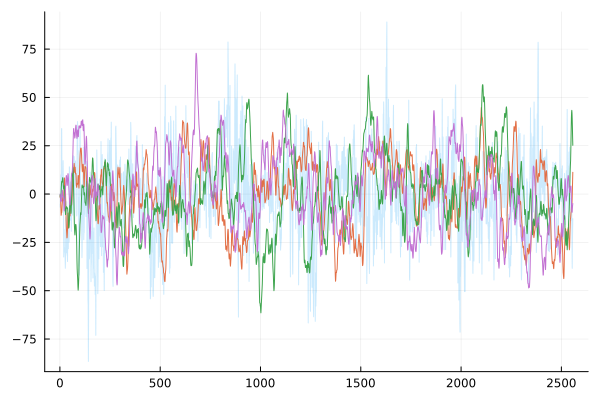

In [167]:
Xj = arfima(N, 1, nothing, SVector(Coffj[2:3]...),SVector(Coffj[4:5]...)) # ARFIMA(2,0,0)
Xp = [arfima(N, 1, nothing, SVector(Coffp[2:3]...),SVector(Coffp[4:5]...)) for i in 1:3]; # ARFIMA(2,0,0)

plot(W, label="W", alpha=0.2)
#plot!(Xj, label="J")
plot!(Xp, label="p")
plot!(leg=false)

# Reszta

## Trend

In [827]:
@. model_trend(x,p)=p[1]+p[2]*x

model_trend (generic function with 1 method)

In [938]:
fits_trend=curve_fit(model_trend,1:N,X,[1.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([25.161203347180614, 5.6842075321836884e-5], [11.536260189255934, 11.036317031331258, 13.161373873406578, 12.01857357262476, 11.590058986128652, 12.911544399632543, 13.411601241707867, 13.786658083783188, 13.411714925858512, 12.411771767933832  …  6.999762425204395, 4.3476453542362385, 9.169130767740132, 8.847759038386883, 10.48417951682584, 9.681206055870861, 8.903485120168405, 9.222986406688168, 10.098043248763492, 8.257190999929723], [1.0000000000008662 1.0000000000235538; 1.0000000000008662 2.0000000000471077; … ; 1.0000000000008662 3286.9999999999777; 1.0000000000008662 3288.0000000000014], true, Float64[])

In [939]:
fits_trend.param

2-element Vector{Float64}:
 25.161203347180614
  5.6842075321836884e-5

In [940]:
ans[2]*365

0.02074735749247046

In [941]:
model_trend(N,fits.param)-model_trend(1,fits.param)

0.18683990158287855

In [942]:
Y=X .- model_trend.(1:N,Ref(fits_trend.param));

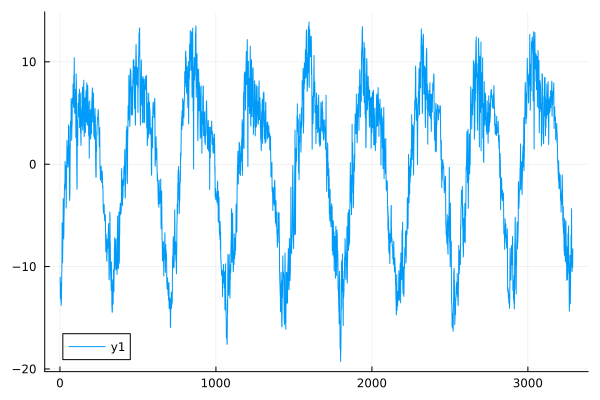

In [943]:
plot(Y)

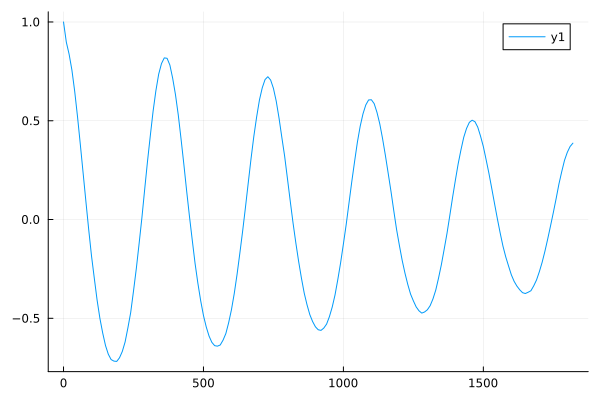

In [944]:
γ₀=γ(Y,0)
plot(0:10:365*5,h->γ(Y,h)/γ₀)

## Sezonowość

###### 1

In [1416]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])

model_ses (generic function with 1 method)

In [1417]:
fit_ses=curve_fit(model_ses,1:N,Y,[1.,365.,0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([9.325083803494246, 365.0, -1.0716173679928707], [3.427114202096959, 3.007626762578113, 5.2155183972592205, 4.1579074175463795, 3.8169114371480672, 5.2282188081267815, 5.820374342869439, 6.289779321974311, 6.011405788052207, 5.110225125439384  …  -1.604047450937518, -4.192989522584623, 0.6942016646762941, 0.44104701347728437, 2.148175660275136, 1.4183805055274767, 0.7162863295692858, 1.1138404195291614, 2.0693529800103274, 0.31133552378232565], [-0.8696056955673375 0.0 4.60423058736915; -0.8609778140350218 0.0 4.743134038839068; … ; -0.8609778140192929 0.0 4.743134040618401; -0.8520948061758706 0.0 4.880631999215779], true, Float64[])

In [1418]:
fit_ses.param

3-element Vector{Float64}:
   9.325083803494246
 365.0
  -1.0716173679928707

In [1419]:
W=Y.-model_ses.(1:N,Ref(fit_ses.param));

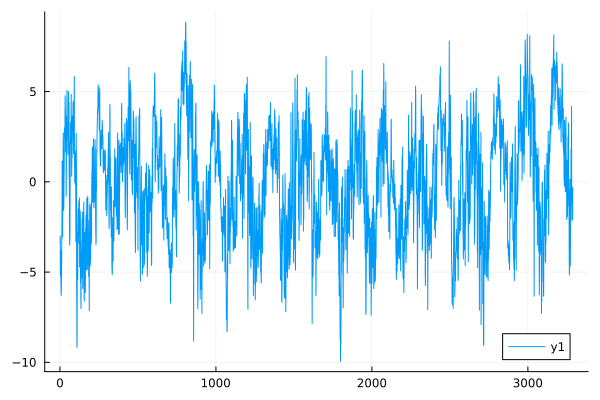

In [1420]:
plot(W)

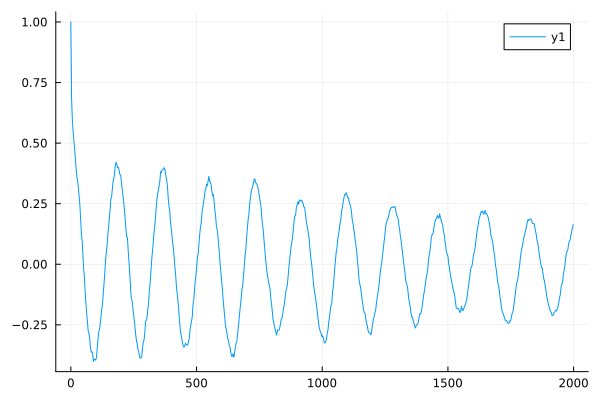

In [1421]:
γ₀=γ(W,0)
plot(0:3:2000,h->γ(W,h)/γ₀)

In [1119]:
γ₀=γ(W,0)
anim=@animate for i in 1:10
    plot(0:3:2000,h->γ(temp!(W,model_ses,fit_ses.param),h)/γ₀, title="$i")
end

Animation("C:\\Users\\Kacper\\AppData\\Local\\Temp\\jl_KZjwTB", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

###### 2

In [1128]:
temp=zeros(100,length(Y));

In [1146]:
temp[1,:]=Y
for i in 2:100
    fit_ses=curve_fit(model_ses,1:N,temp[i-1,:],[1.,365.,0.])
    temp[i,:]=temp[i-1,:].-model_ses.(1:N,Ref(fit_ses.param))
end

In [1147]:
anim=@animate for i in 36:38
    γ₀=γ(temp[i,:],0)
    plot(0:3:2000,h->γ(temp[i,:],h)/γ₀, title="$(i-1)")
end

Animation("C:\\Users\\Kacper\\AppData\\Local\\Temp\\jl_SyDKXi", ["000001.png", "000002.png", "000003.png"])

###### 3

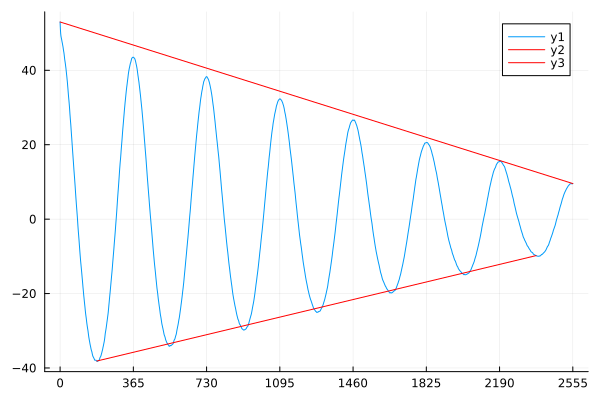

In [1700]:
plot(0:1:7*365,h->γ(Y,h))
plot!([0,7*365],[γ(Y,0),γ(Y,7*365)],c=:red)
plot!([183,7*365-183],[γ(Y,183),γ(Y,7*365-183)],c=:red)
plot!(xticks=[i*365 for i in 0:7])

In [1701]:
(γ(Y,7*365)-γ(Y,0))/(7*365),γ(Y,0)

(-0.016996999041300708, 52.98277224739827)

In [1707]:
(γ(Y,7*365-183)-γ(Y,183))/(6*365)

0.012935707672177756

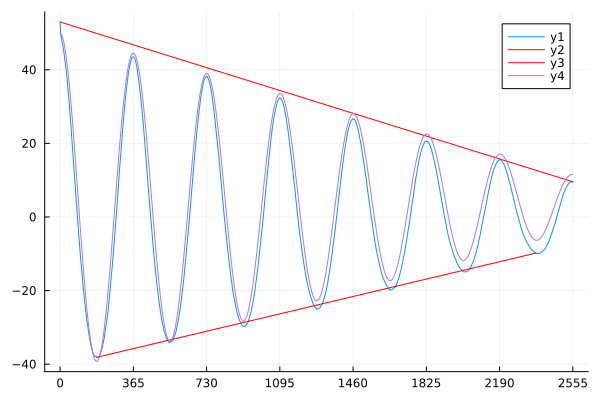

In [1727]:
plot(0:1:7*365,h->γ(Y,h))
plot!([0,7*365],[γ(Y,0),γ(Y,7*365)],c=:red)
plot!([183,7*365-183],[γ(Y,183),γ(Y,7*365-183)],c=:red)
plot!(xticks=[i*365 for i in 0:7])
plot!(h->model_ses(h,[-0.015,366.,π/2,46.,4]))

[-4.9361743166601856e-5, 366.3459730130054, 2.172577314620264, -9.266789928392592, -0.020844747566505735]

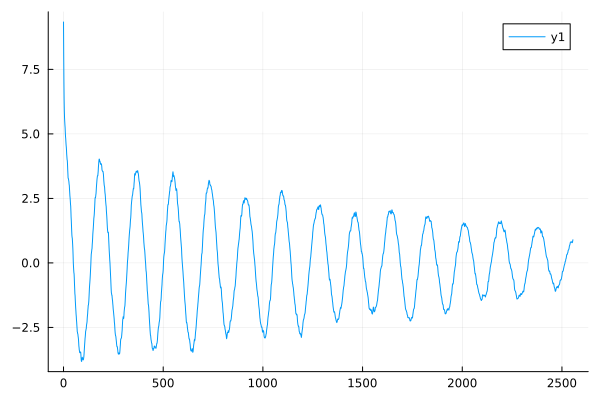

In [1728]:
@. model_ses(x,p)=(p[1]*x+p[4])*sin(2π/p[2]*x+p[3])+p[5]
fit_ses=curve_fit(model_ses,1:N,Y,[-0.017,365.,π/2,53.,3.])
print(fit_ses.param)
W=Y.-model_ses.(1:N,Ref(fit_ses.param));
plot(0:1:7*365,h->γ(W,h))

[1.0638938139464655, 366.30616896160313, 1.5852792628791066, 0.01320429937948623, 42.196739667259536]

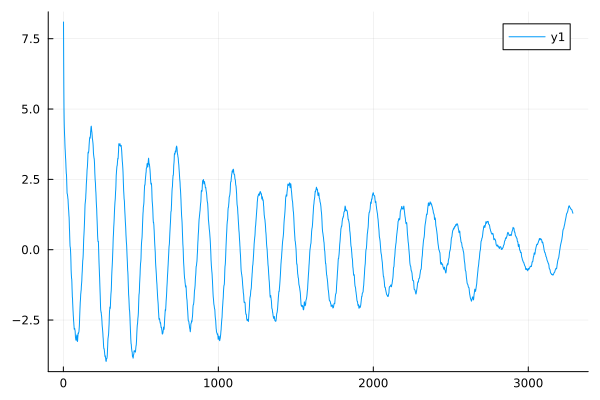

In [1698]:
@. model_ses(x,p)=p[1]*sin(2π/p[2]*x+p[3])*(p[5]-p[4]*x)
fit_ses=curve_fit(model_ses,1:N,γ.(Ref(Y),1:N),[1.,365.,2.,0.024,1.])
print(fit_ses.param)
W=Y.-model_ses.(1:N,Ref(fit_ses.param));
plot(γ.(Ref(Y),0:N-1).-model_ses.(0:N-1,Ref(fit_ses.param)))